Device: cuda
Loading 10 subjects from /content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET...

--------------------------------------------------------------------------------
 >>> Starting LOSO (count-only, K-auto)
--------------------------------------------------------------------------------
Fold  1 | Test: subject1 | MAE: 7.30 | [Pred: 28.3 / GT: 21]
[Fold TEST Summary] subject1 | GT=21 | Pred=28.30 | Diff=+7.30 | k_hat=1.69 | phase_entropy=0.631
Fold  2 | Test: subject2 | MAE: 4.94 | [Pred: 14.1 / GT: 19]
[Fold TEST Summary] subject2 | GT=19 | Pred=14.06 | Diff=-4.94 | k_hat=2.21 | phase_entropy=0.819
Fold  3 | Test: subject3 | MAE: 1.14 | [Pred: 19.9 / GT: 21]
[Fold TEST Summary] subject3 | GT=21 | Pred=19.86 | Diff=-1.14 | k_hat=1.61 | phase_entropy=0.603
Fold  4 | Test: subject4 | MAE: 4.97 | [Pred: 25.0 / GT: 20]
[Fold TEST Summary] subject4 | GT=20 | Pred=24.97 | Diff=+4.97 | k_hat=1.54 | phase_entropy=0.530
Fold  5 | Test: subject5 | MAE: 1.01 | [Pred: 21.0 / GT: 

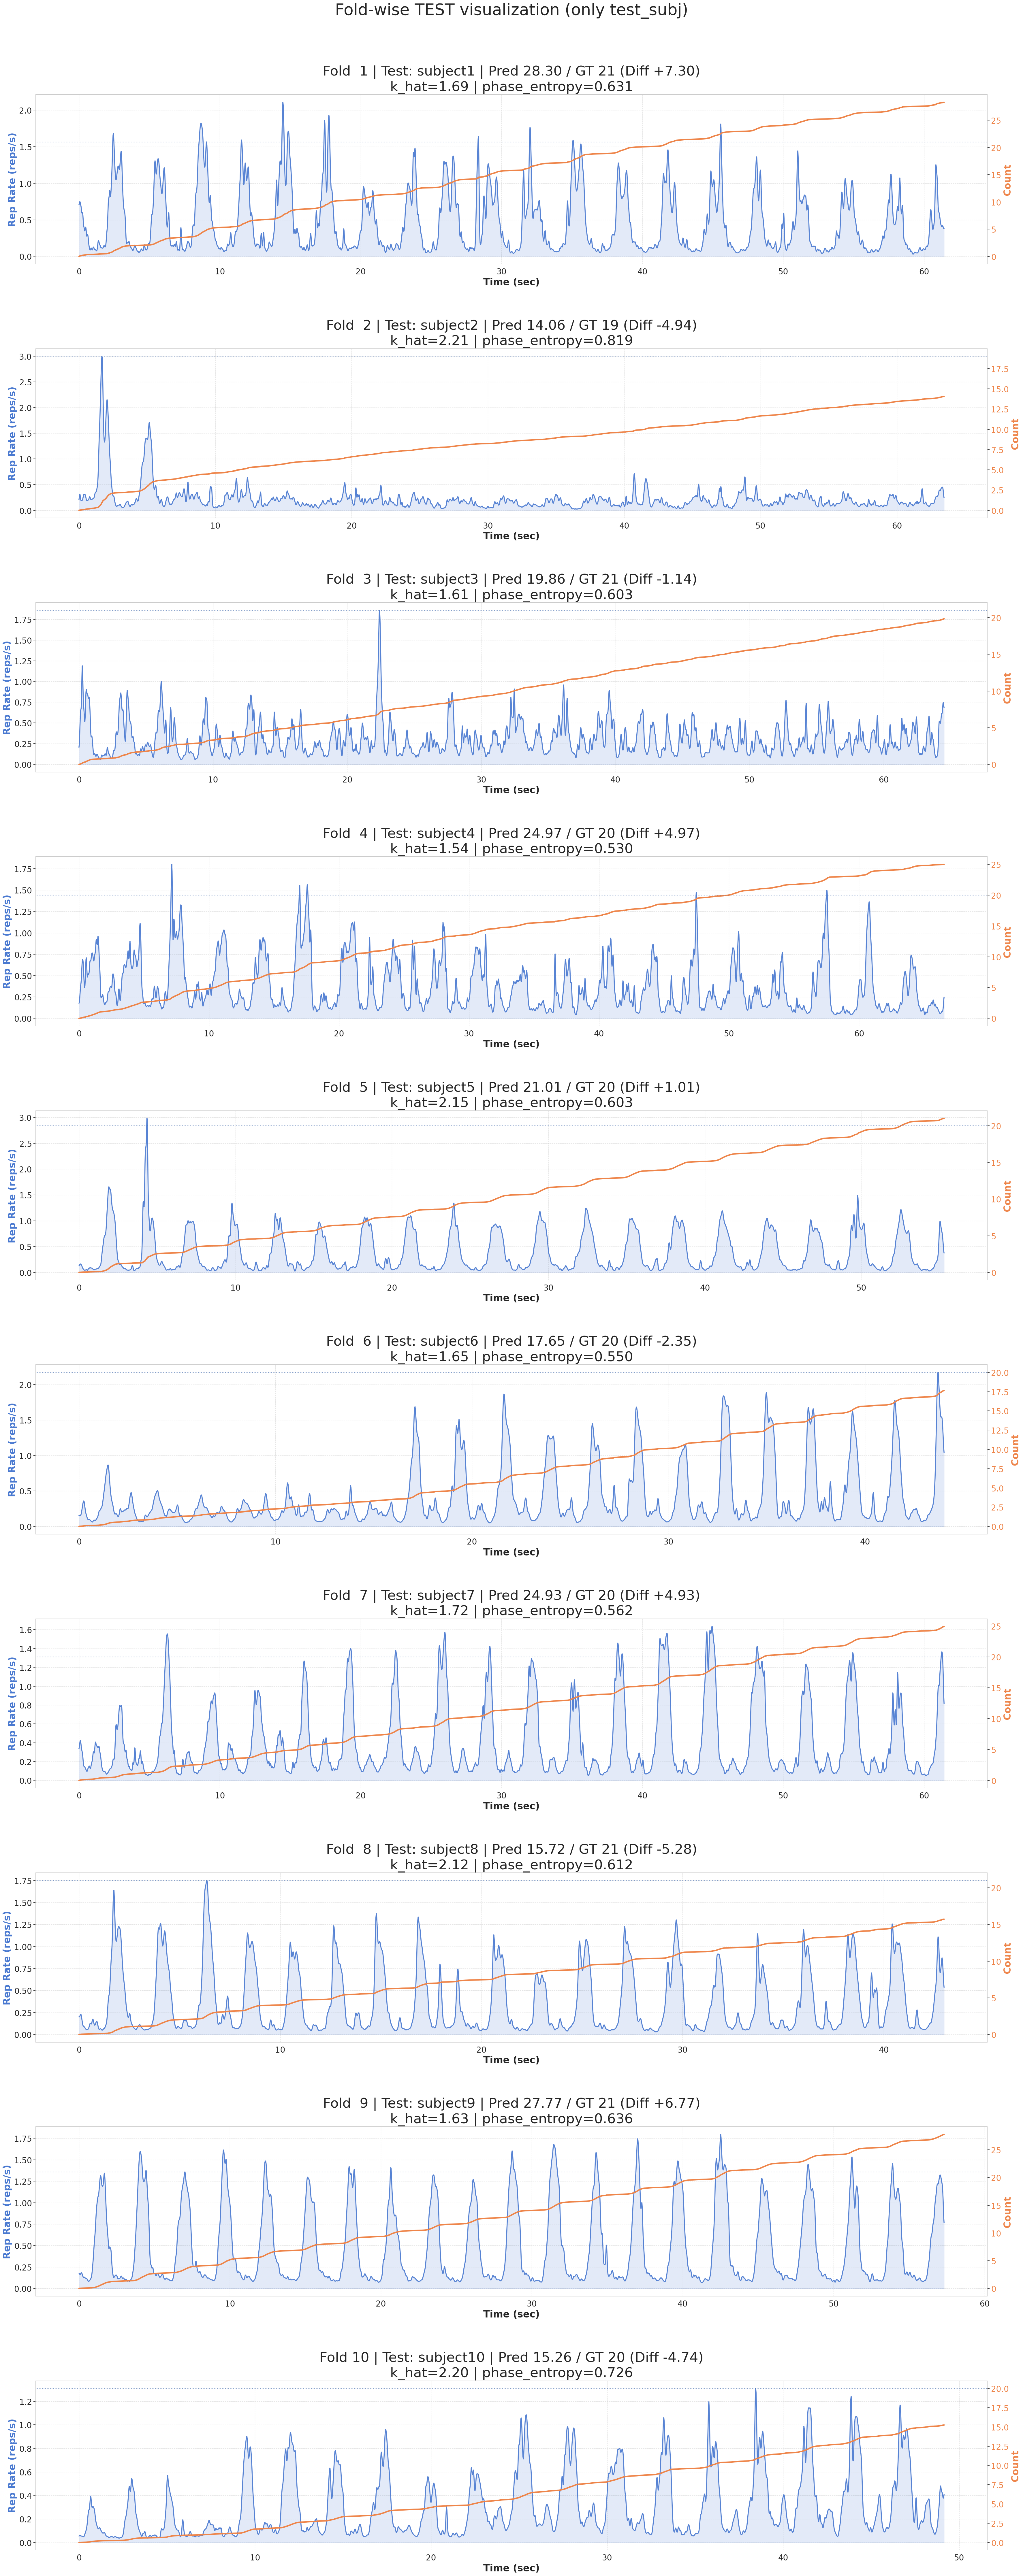

/tmp/ipython-input-3016134631.py:507: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


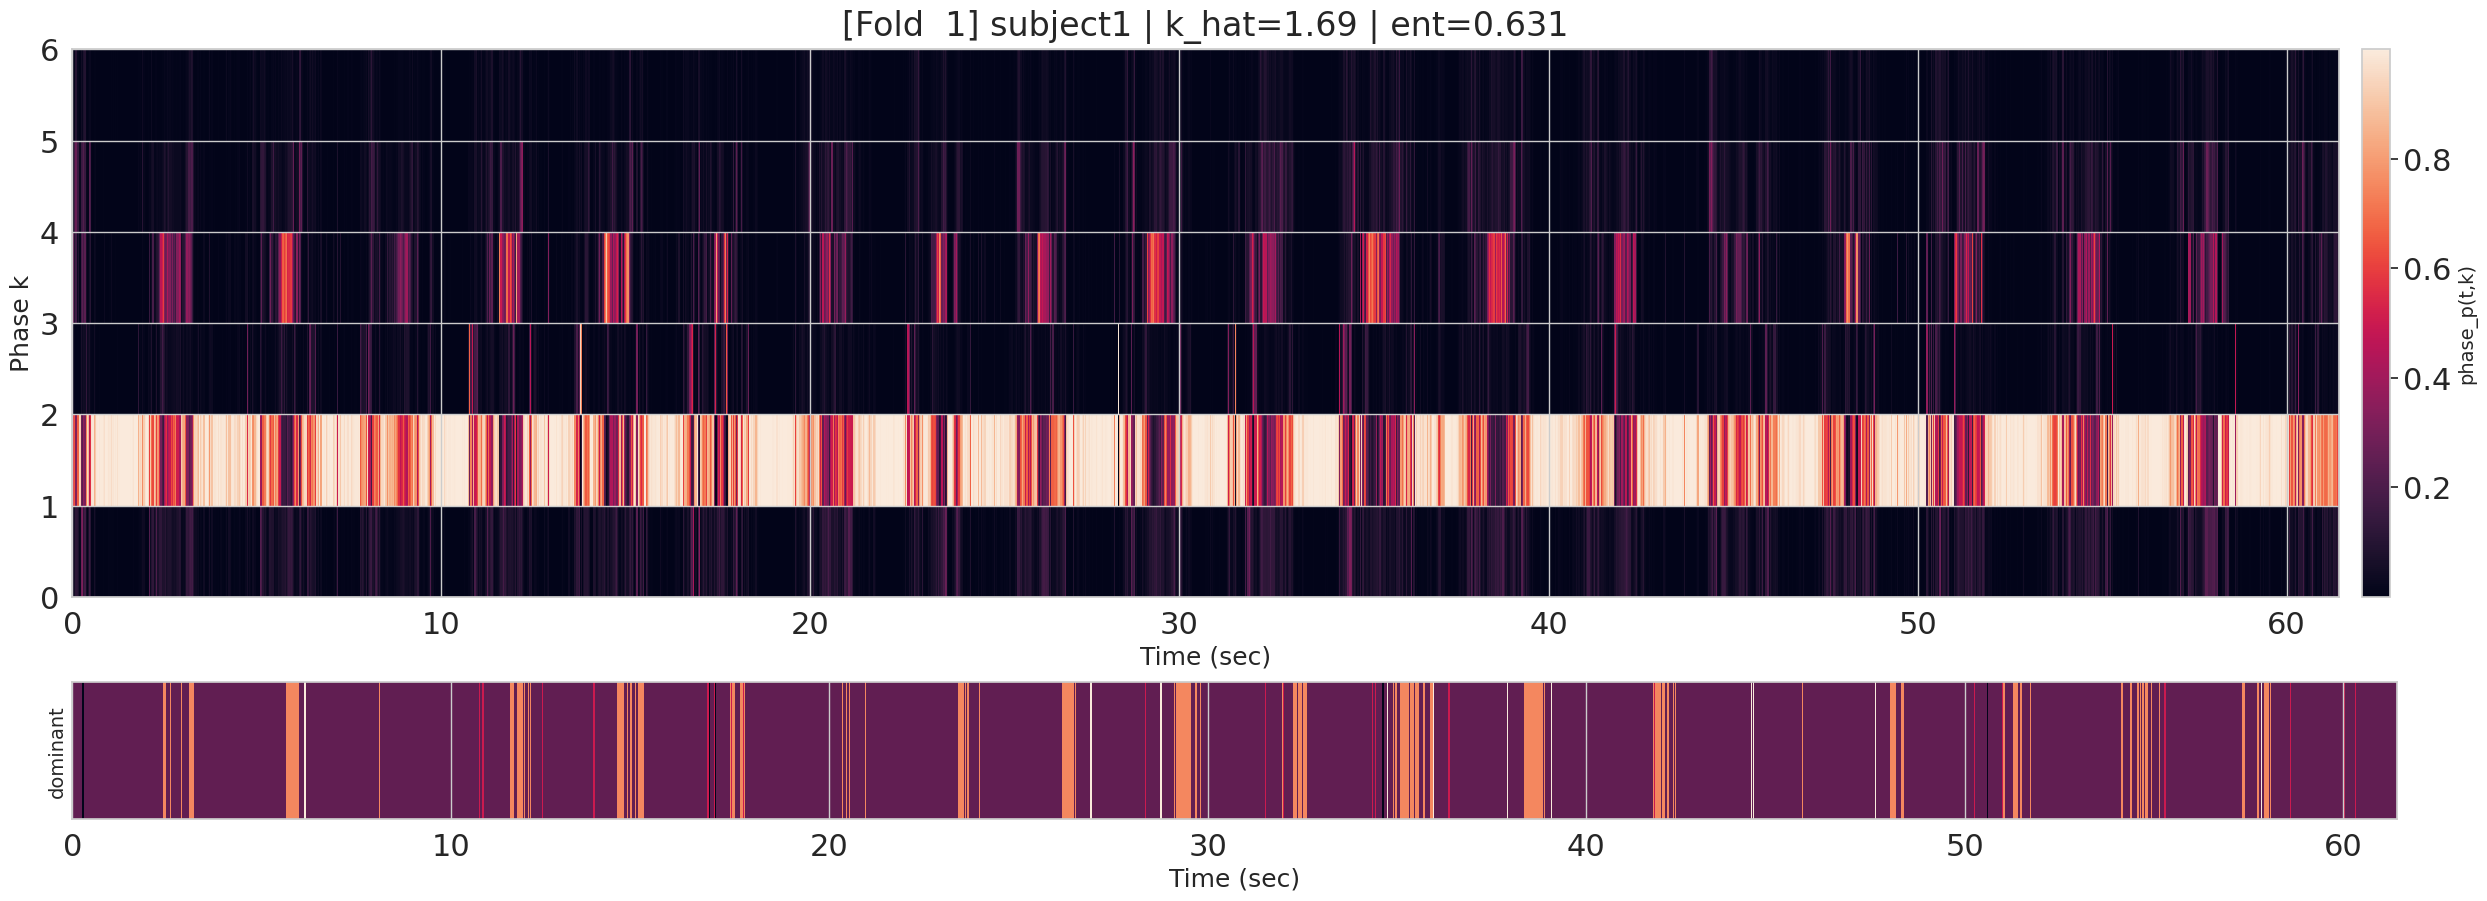

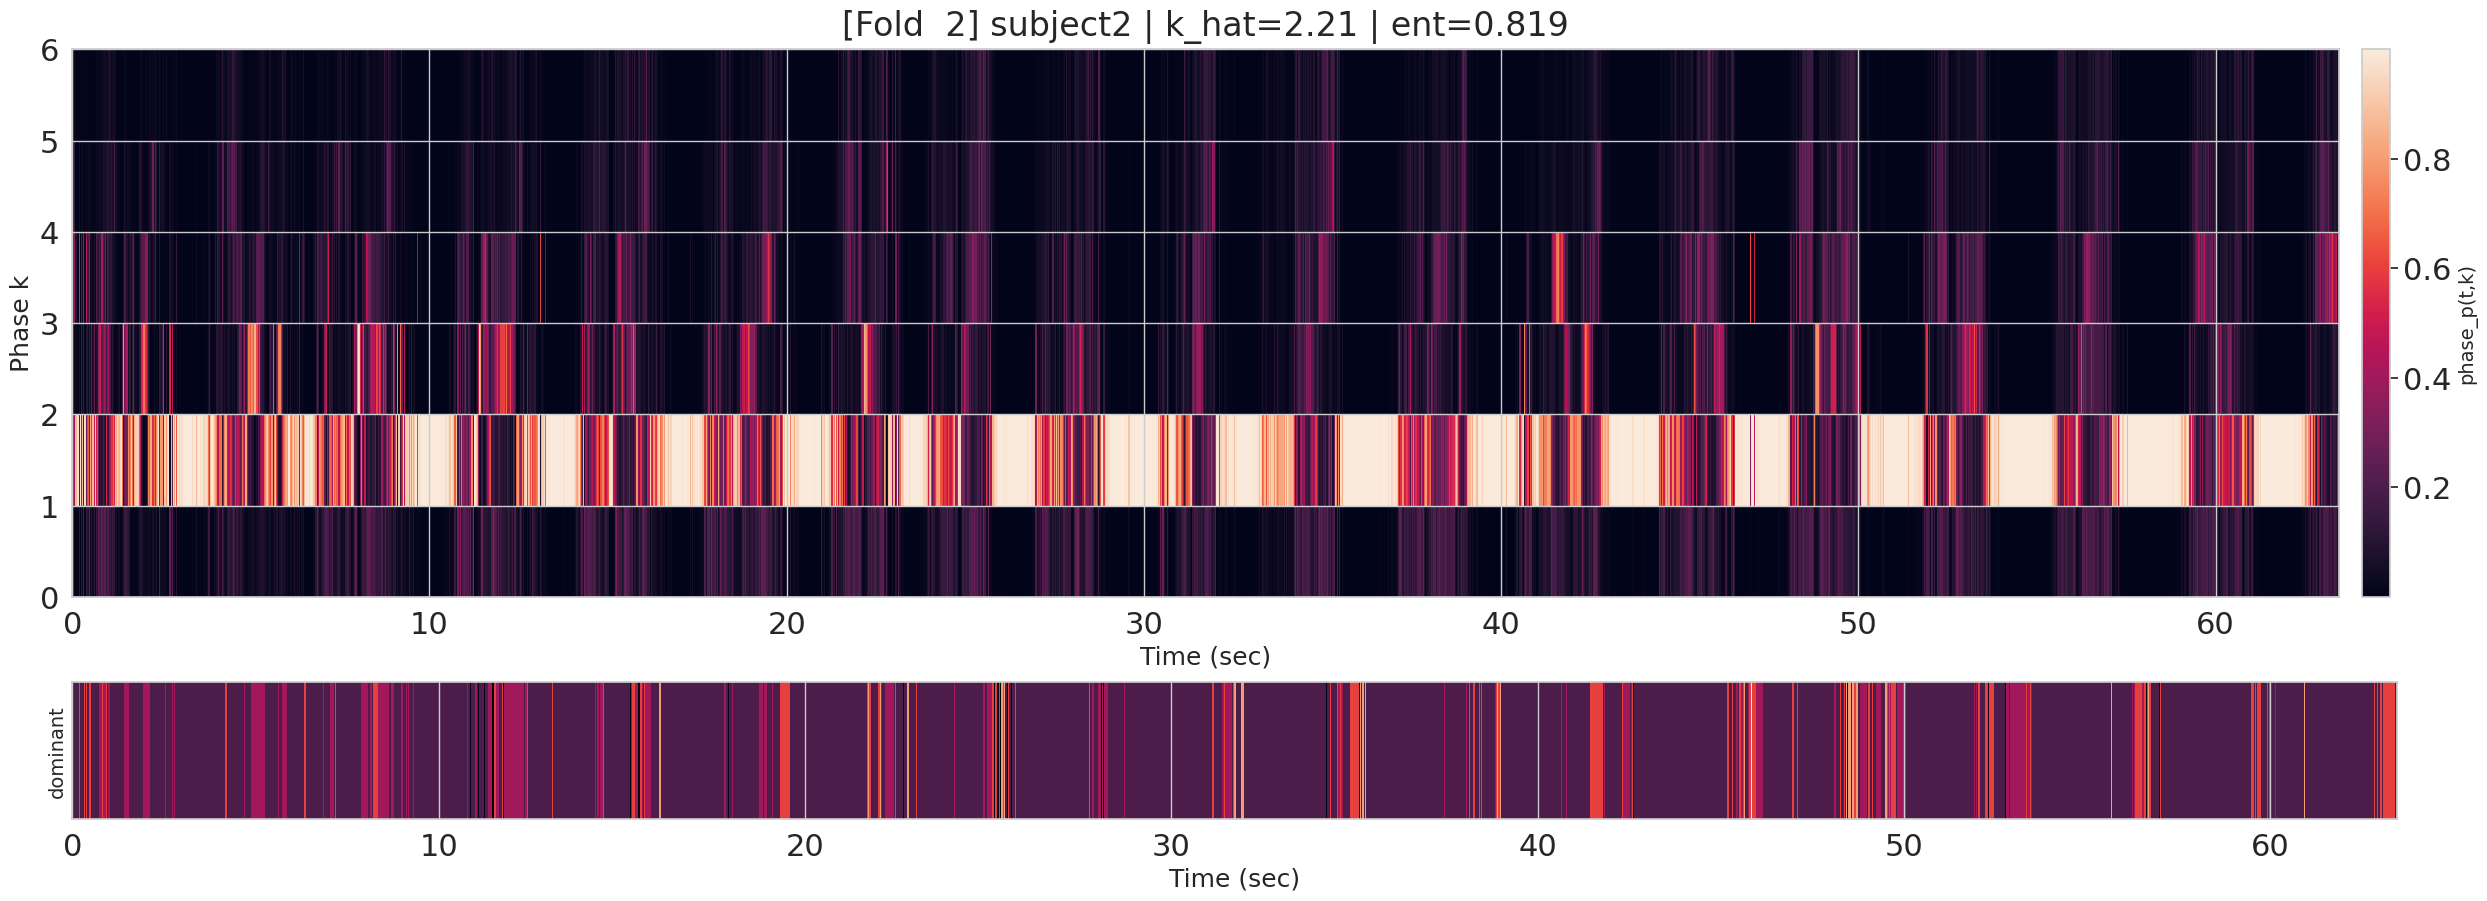

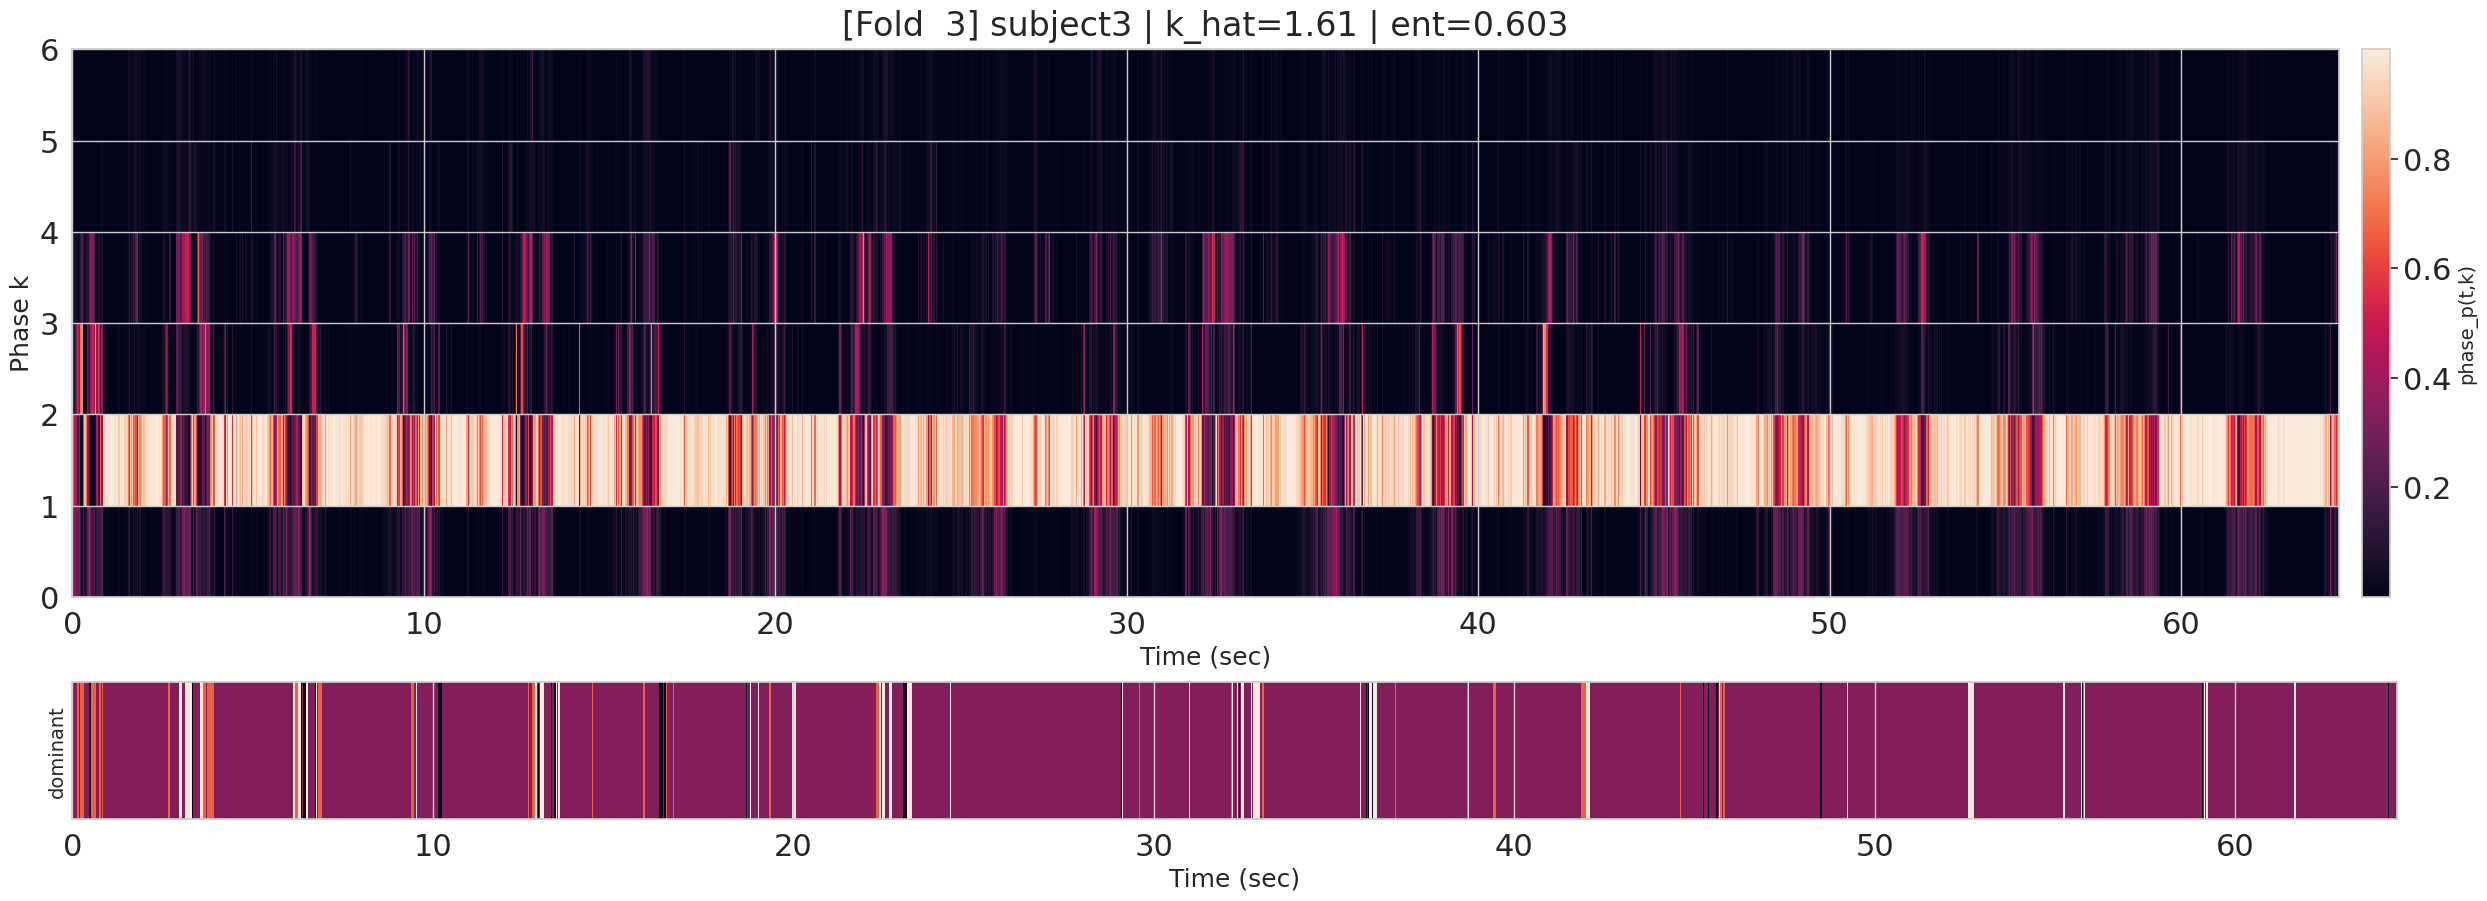

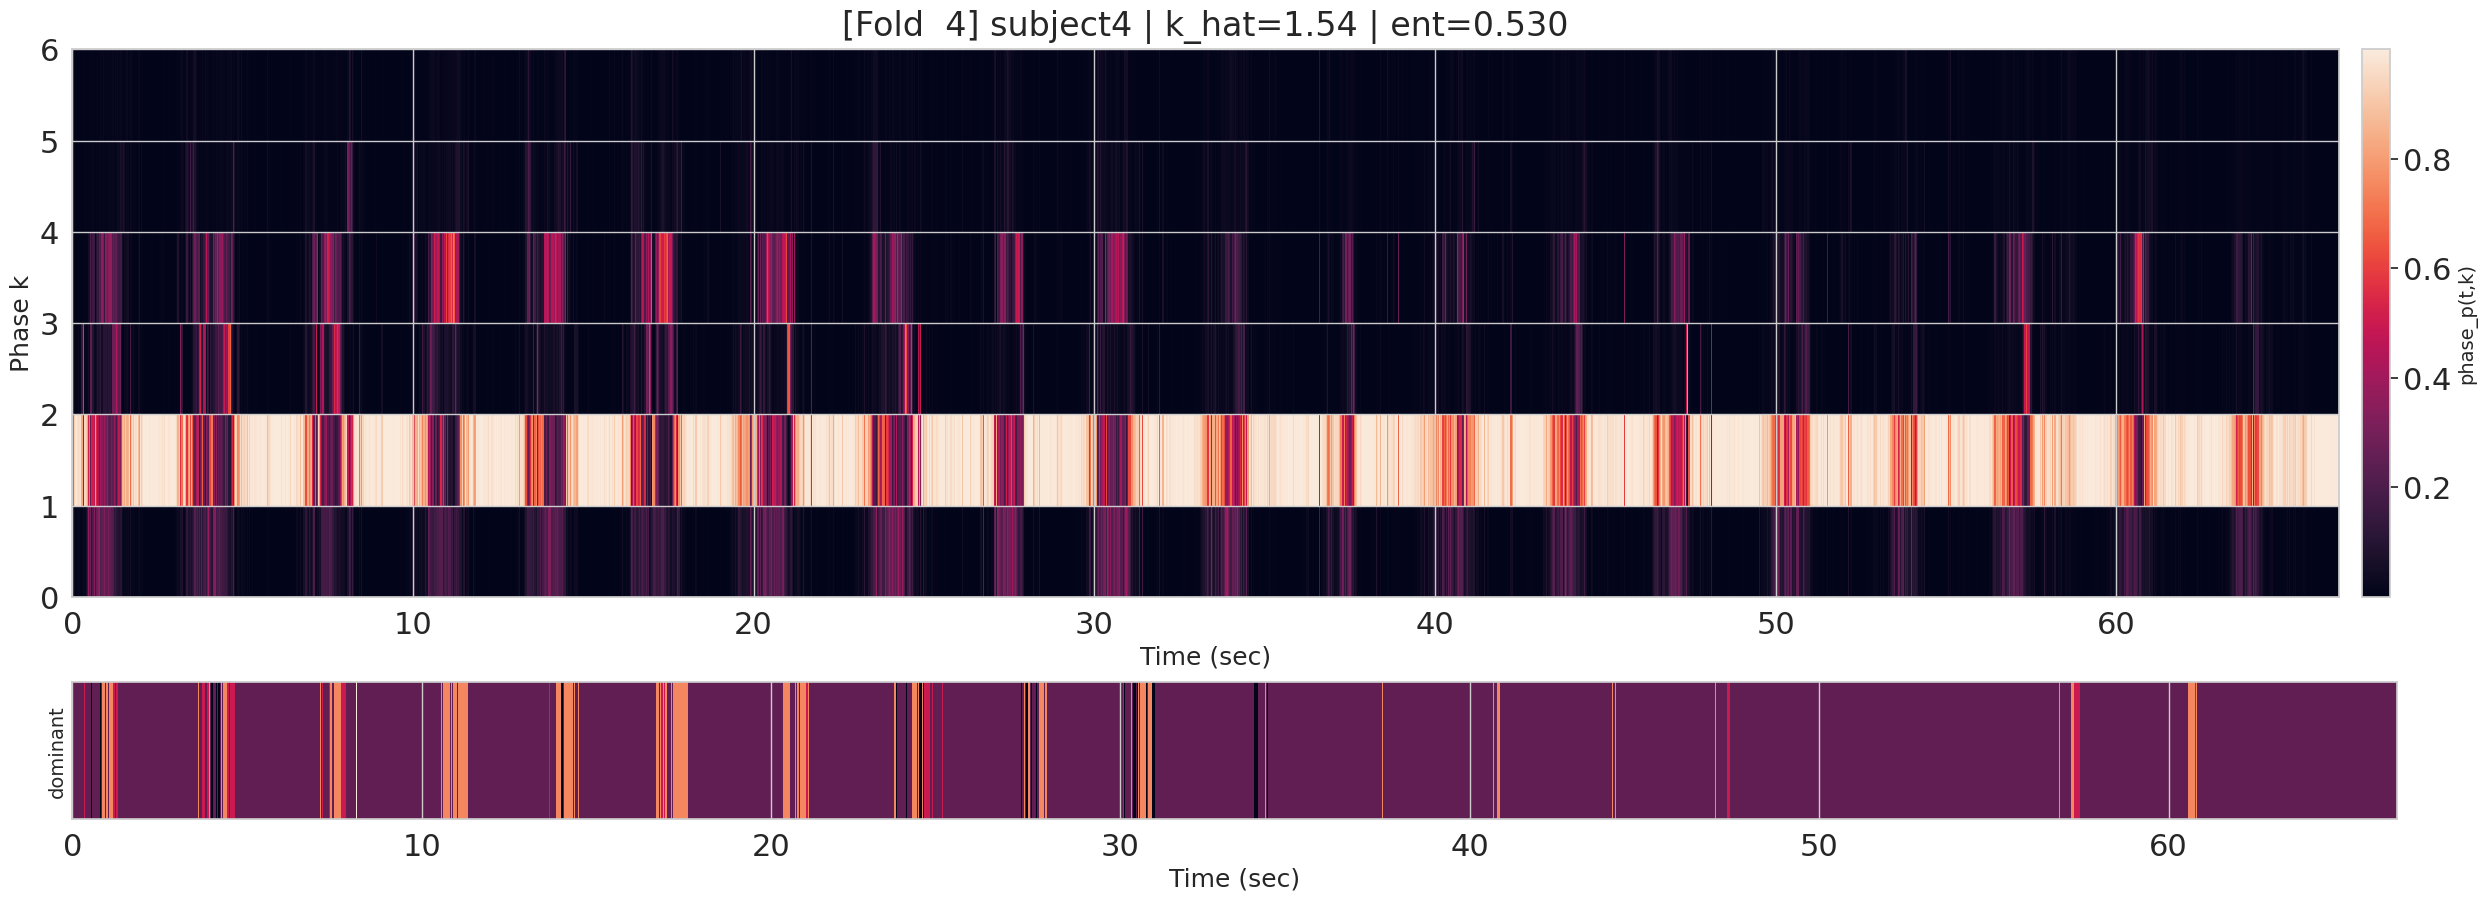

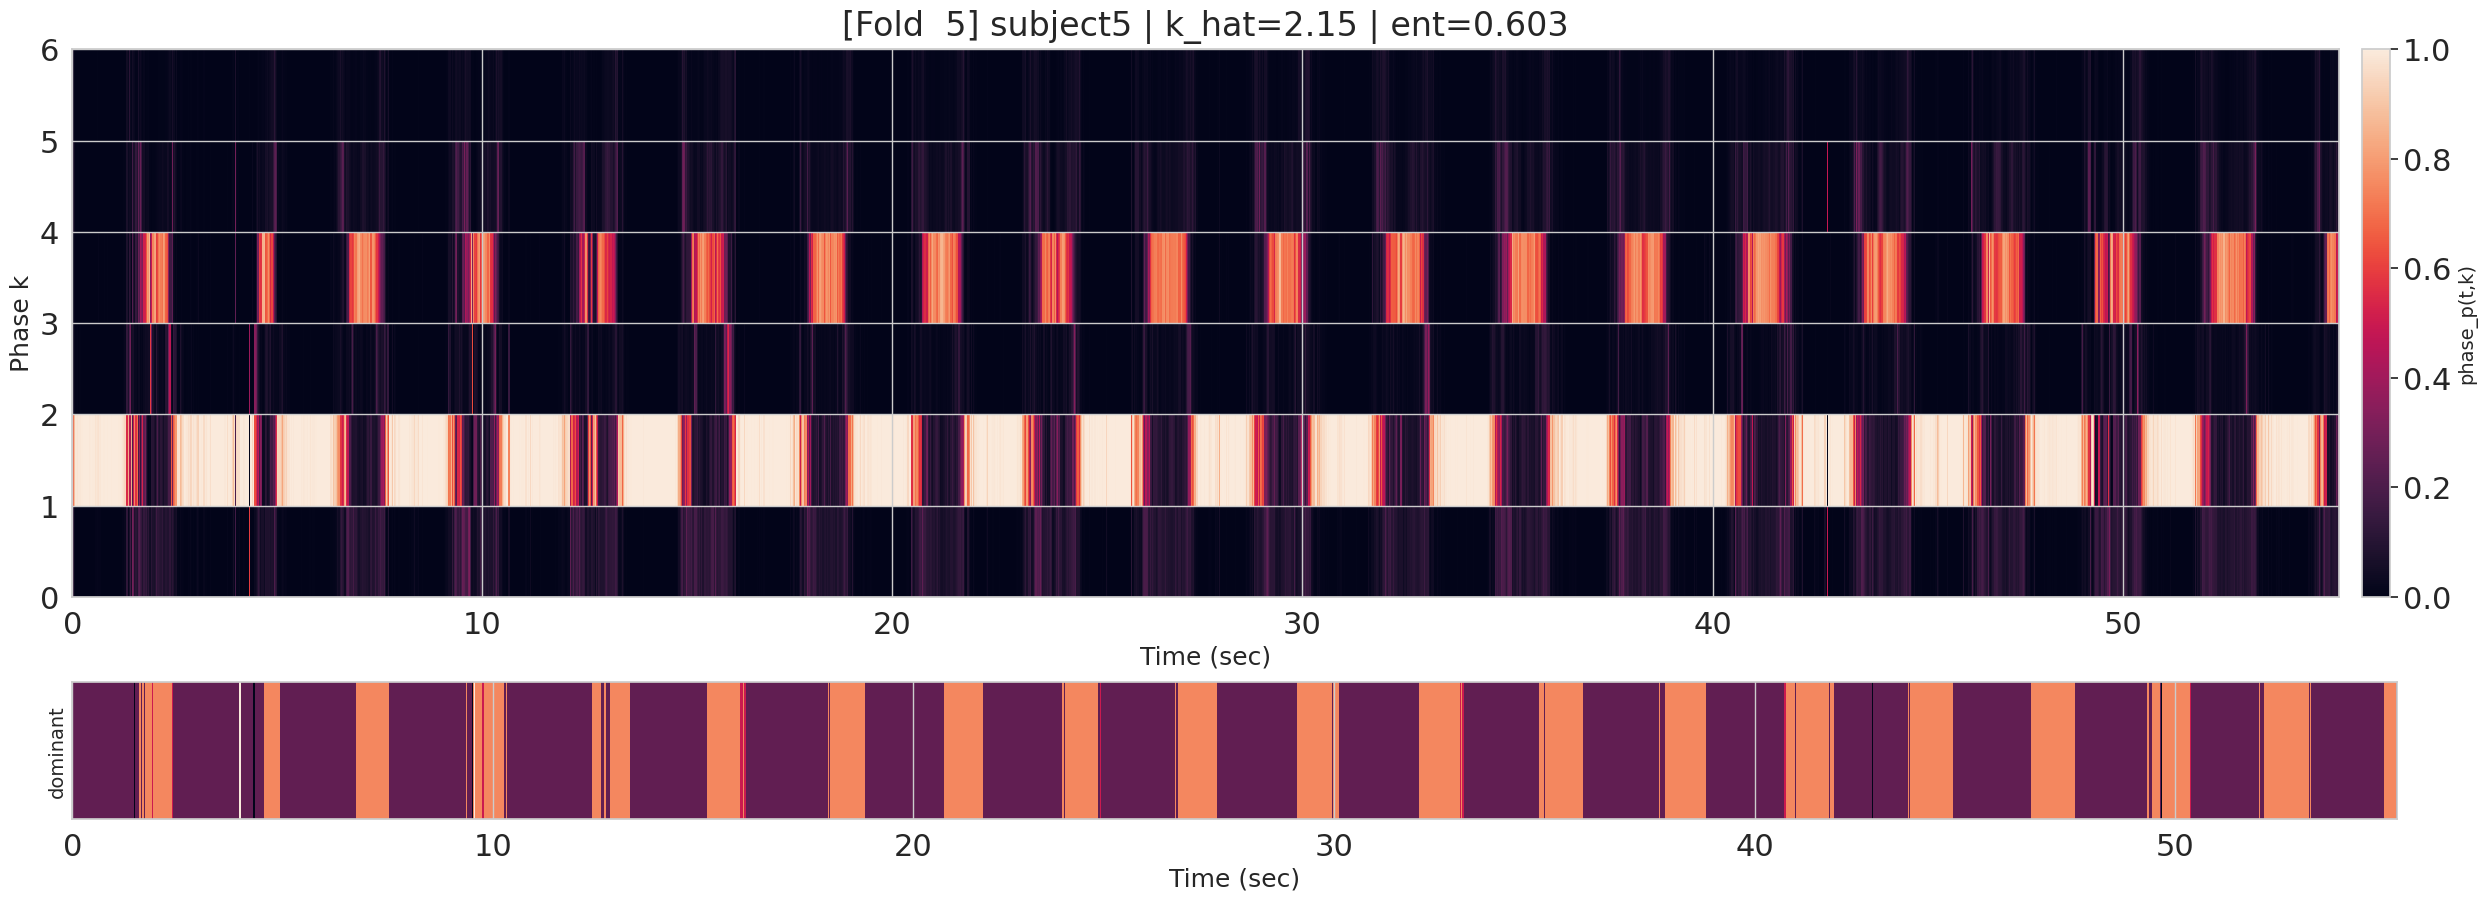

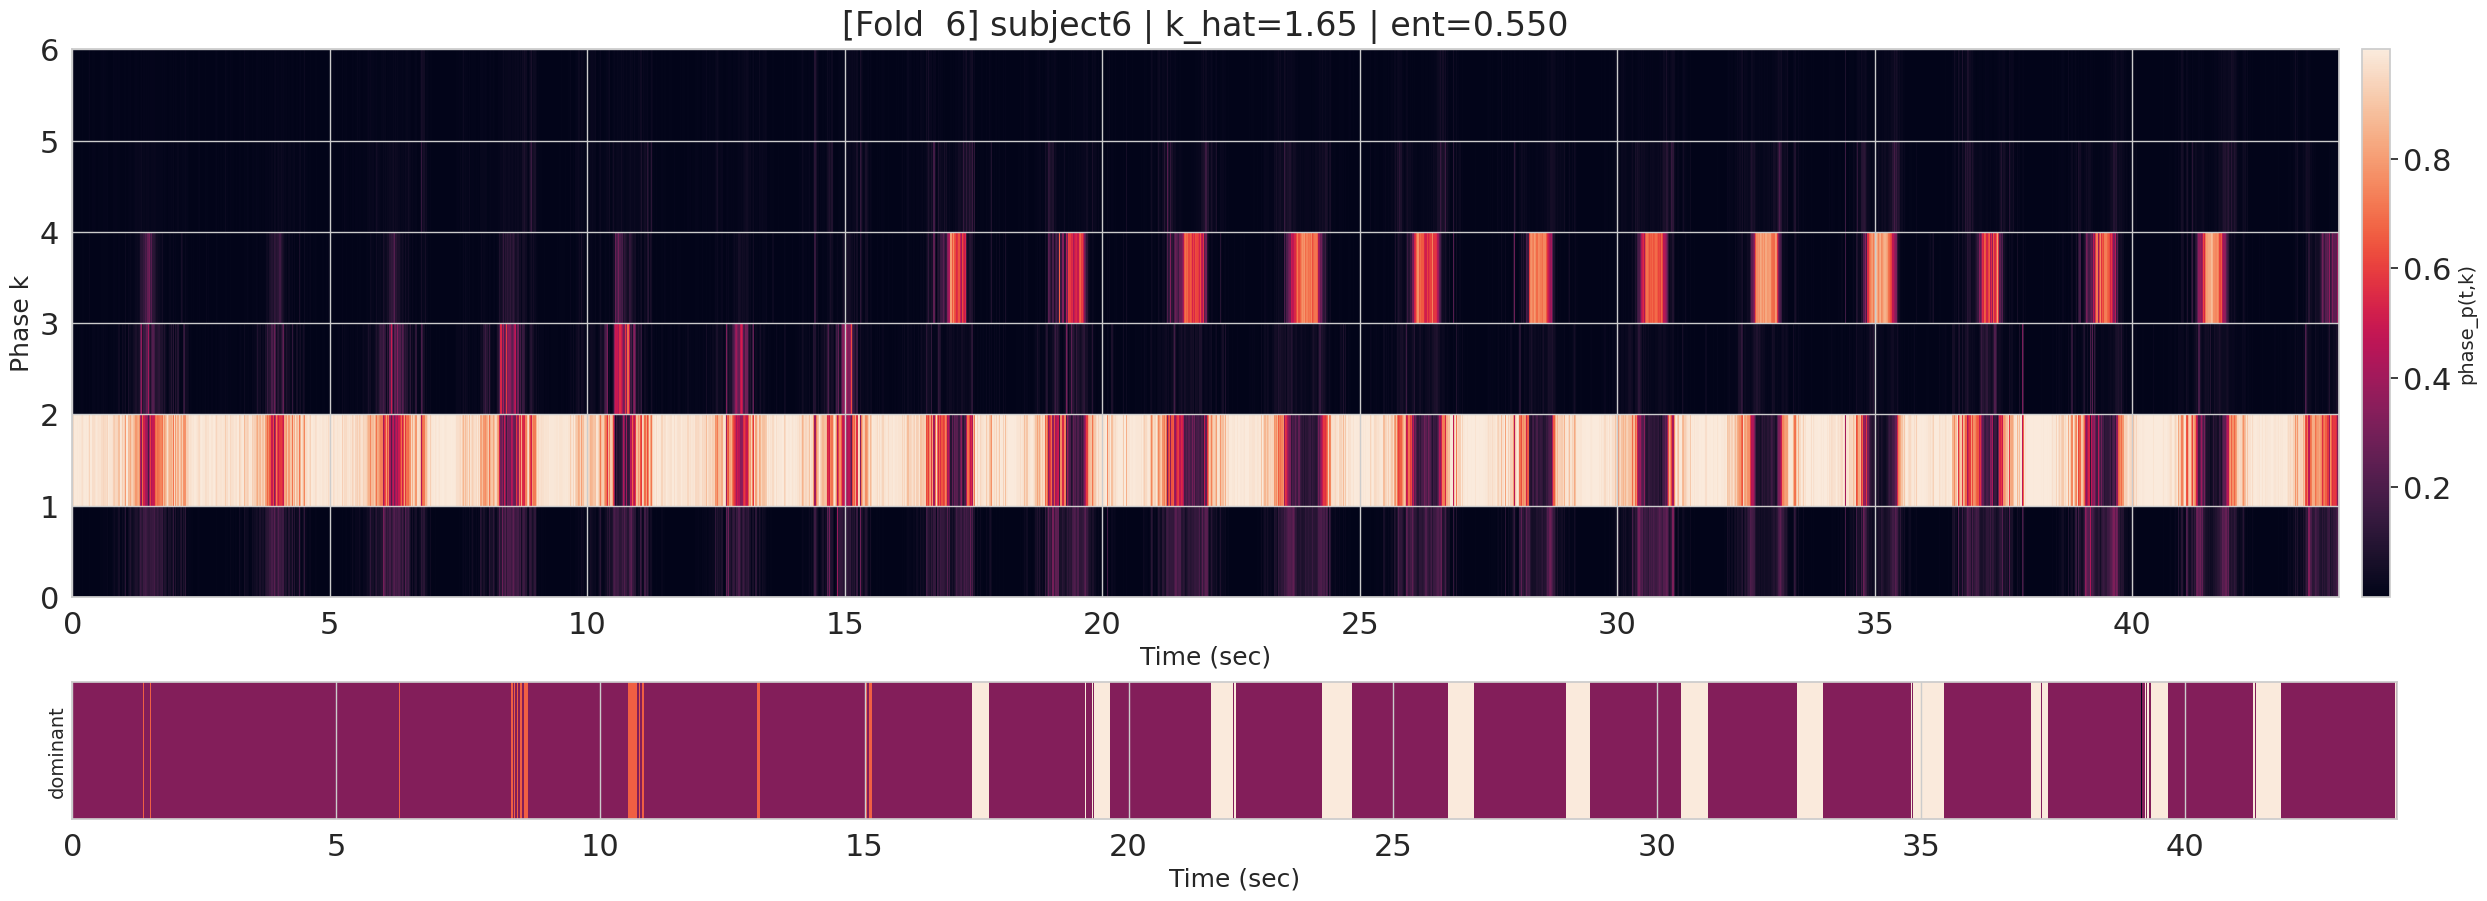

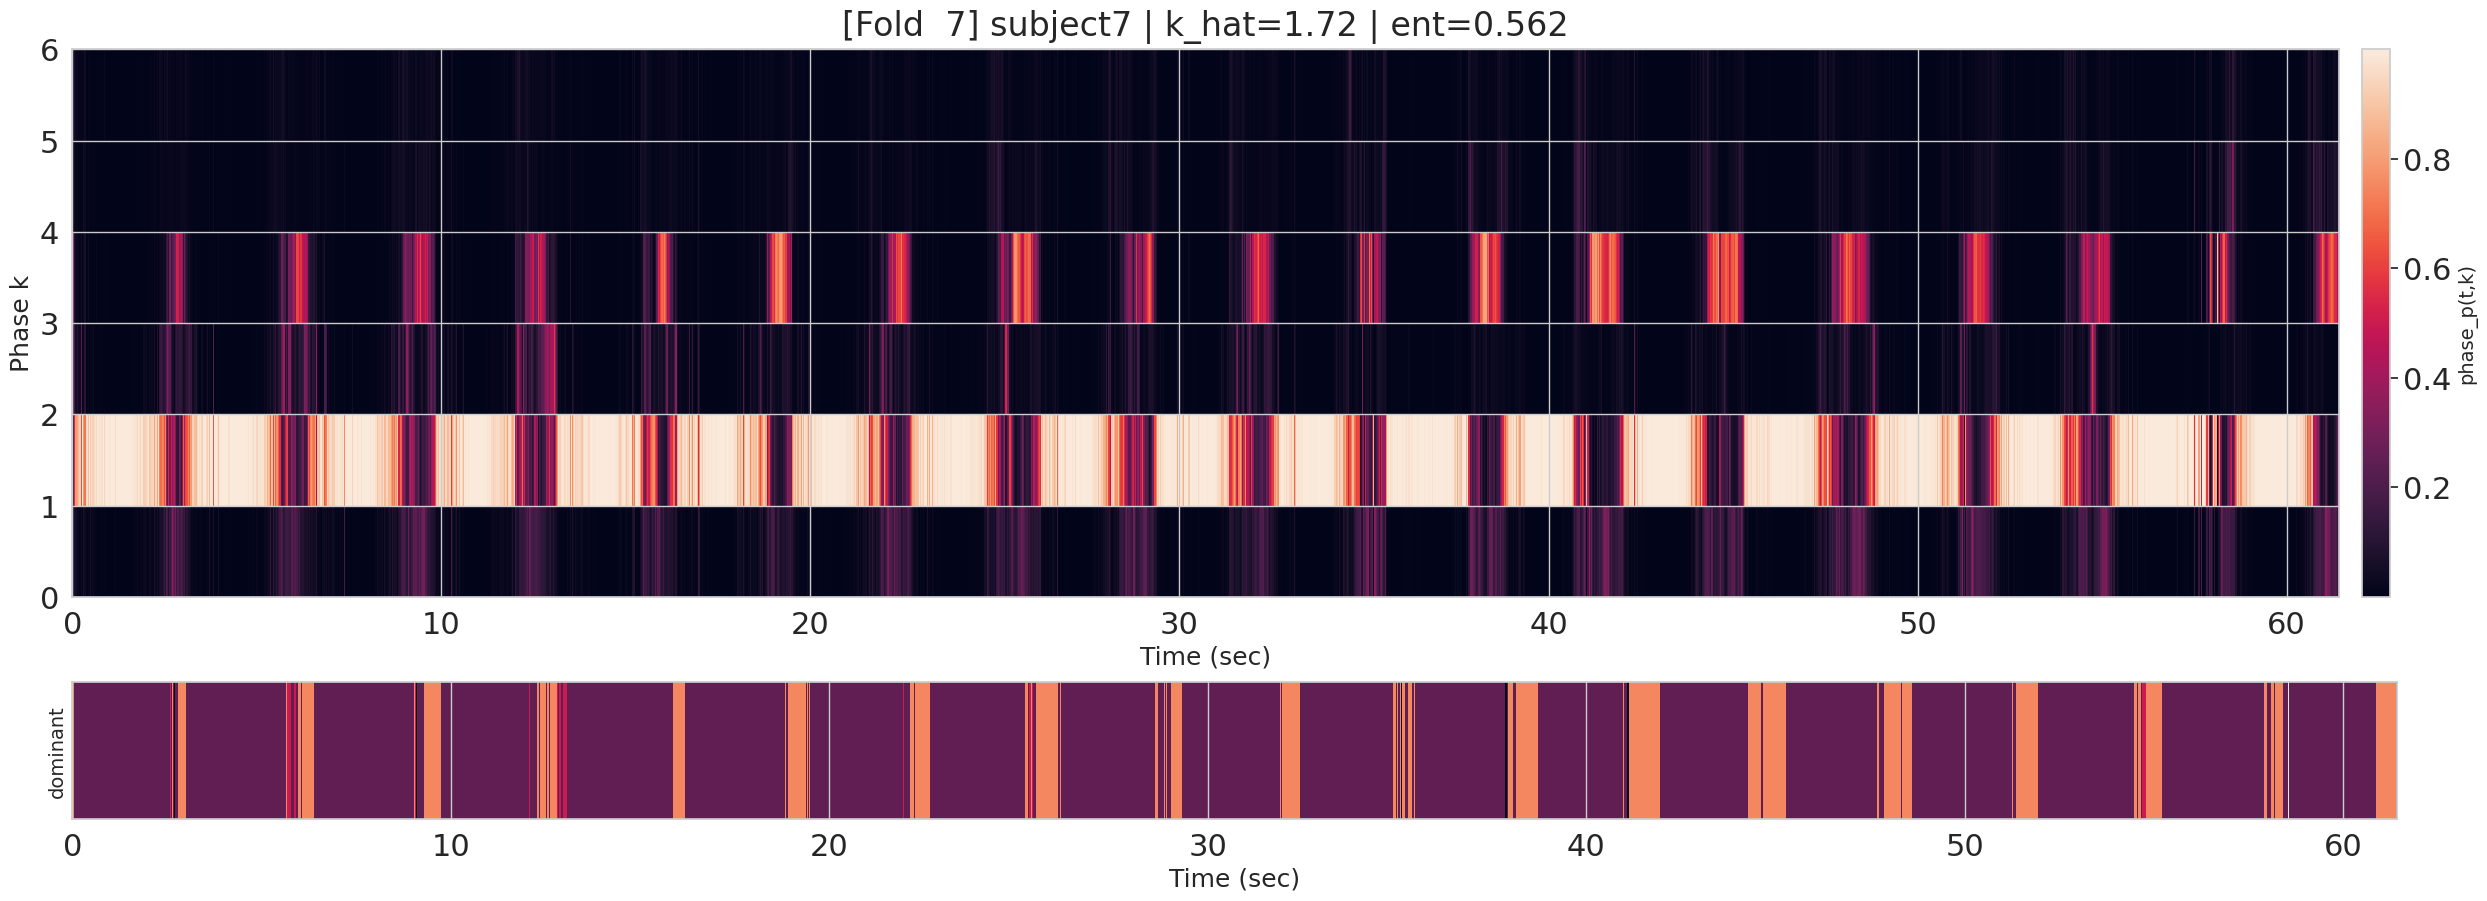

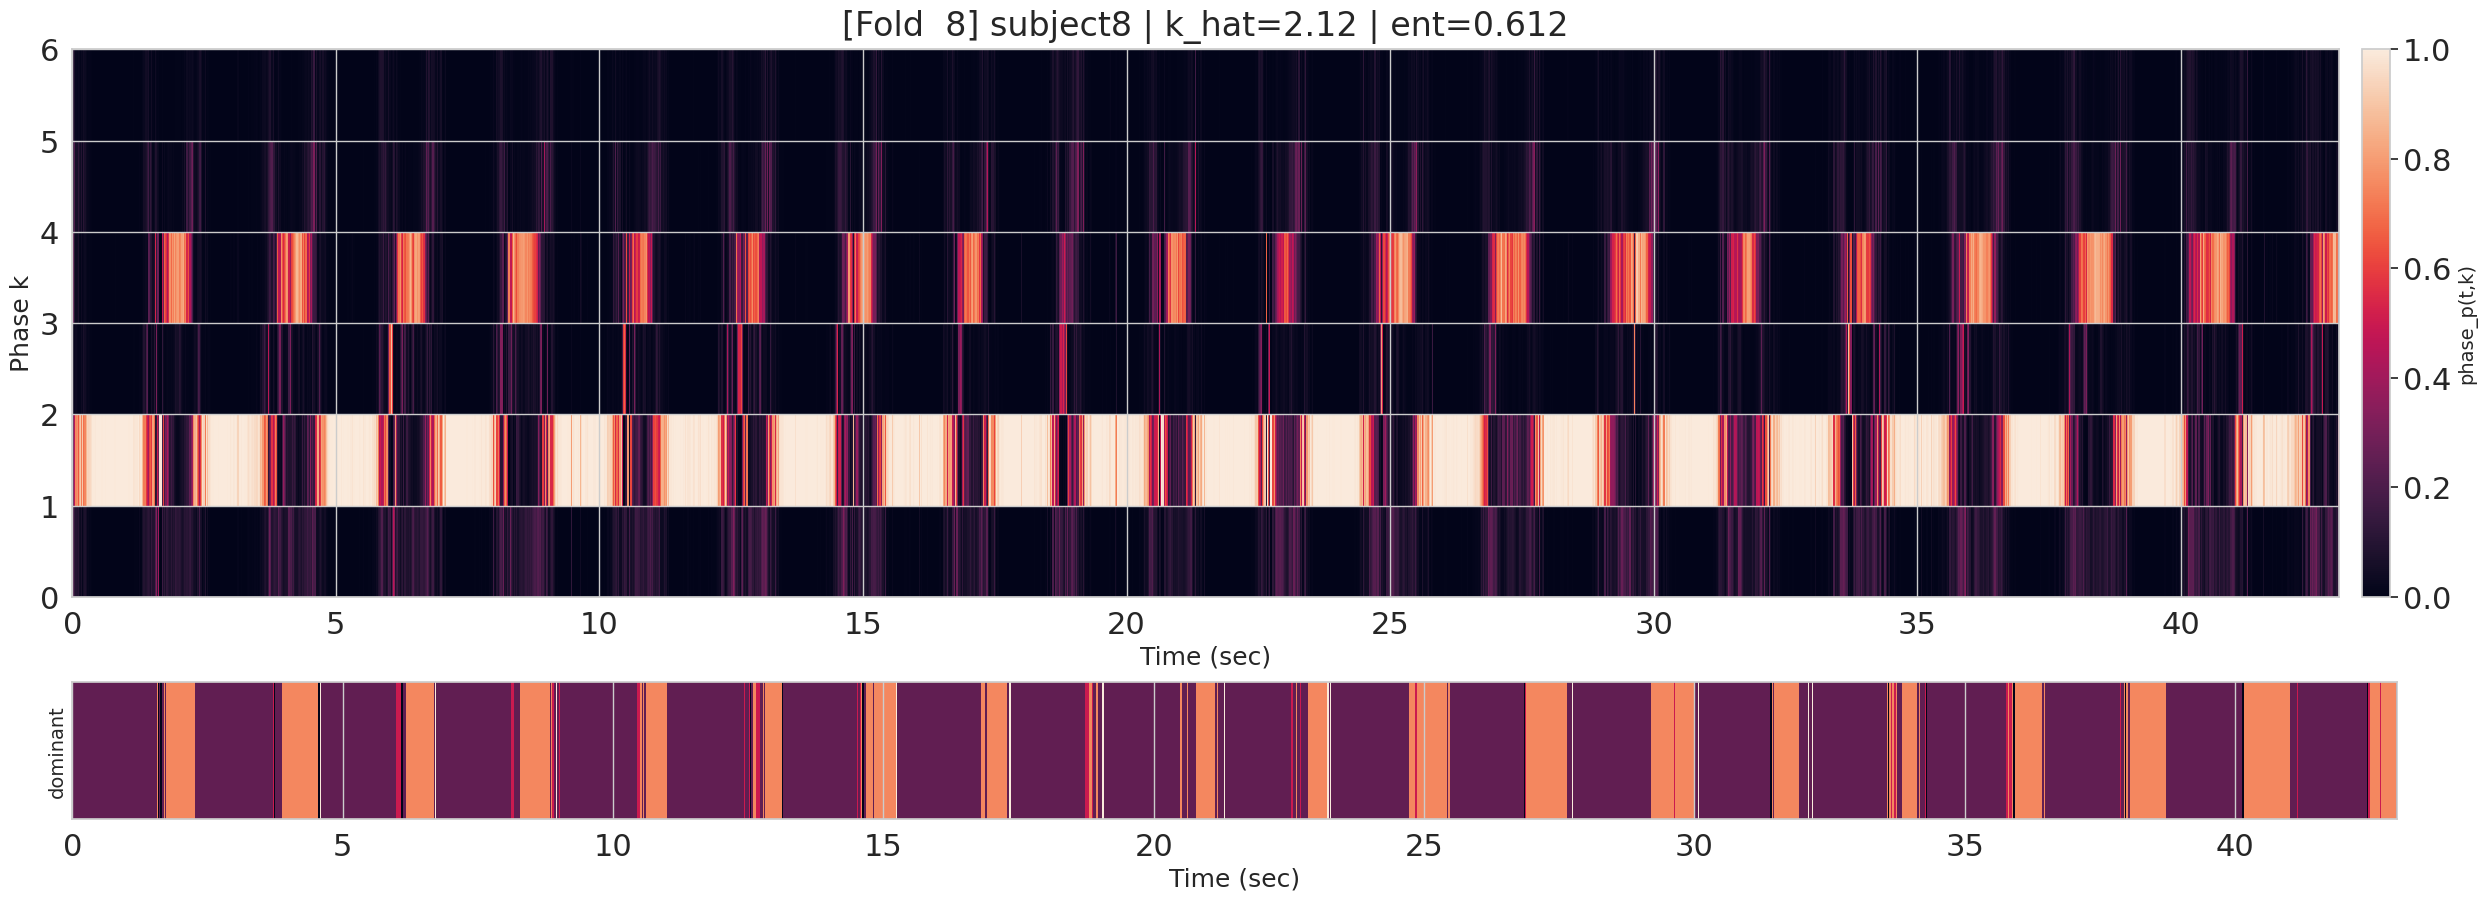

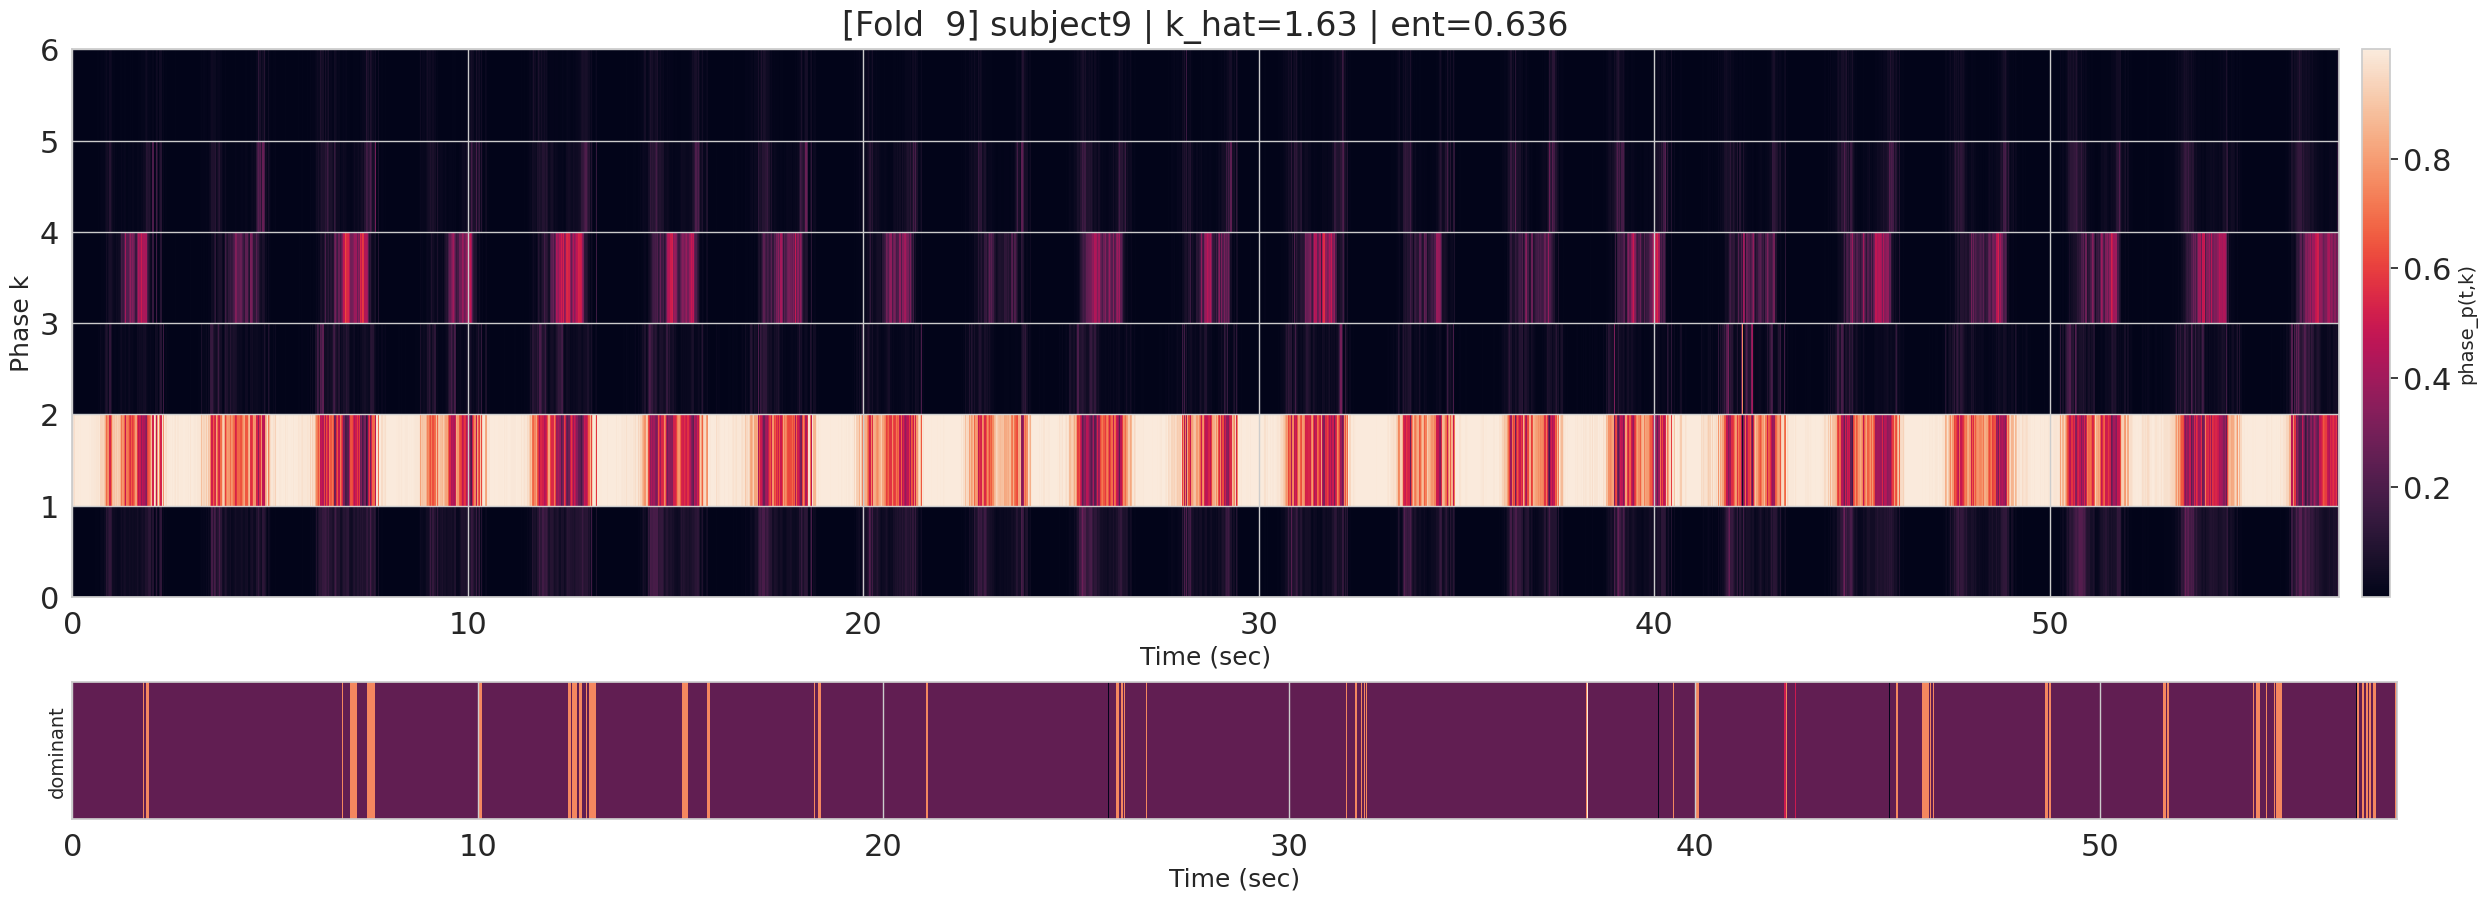

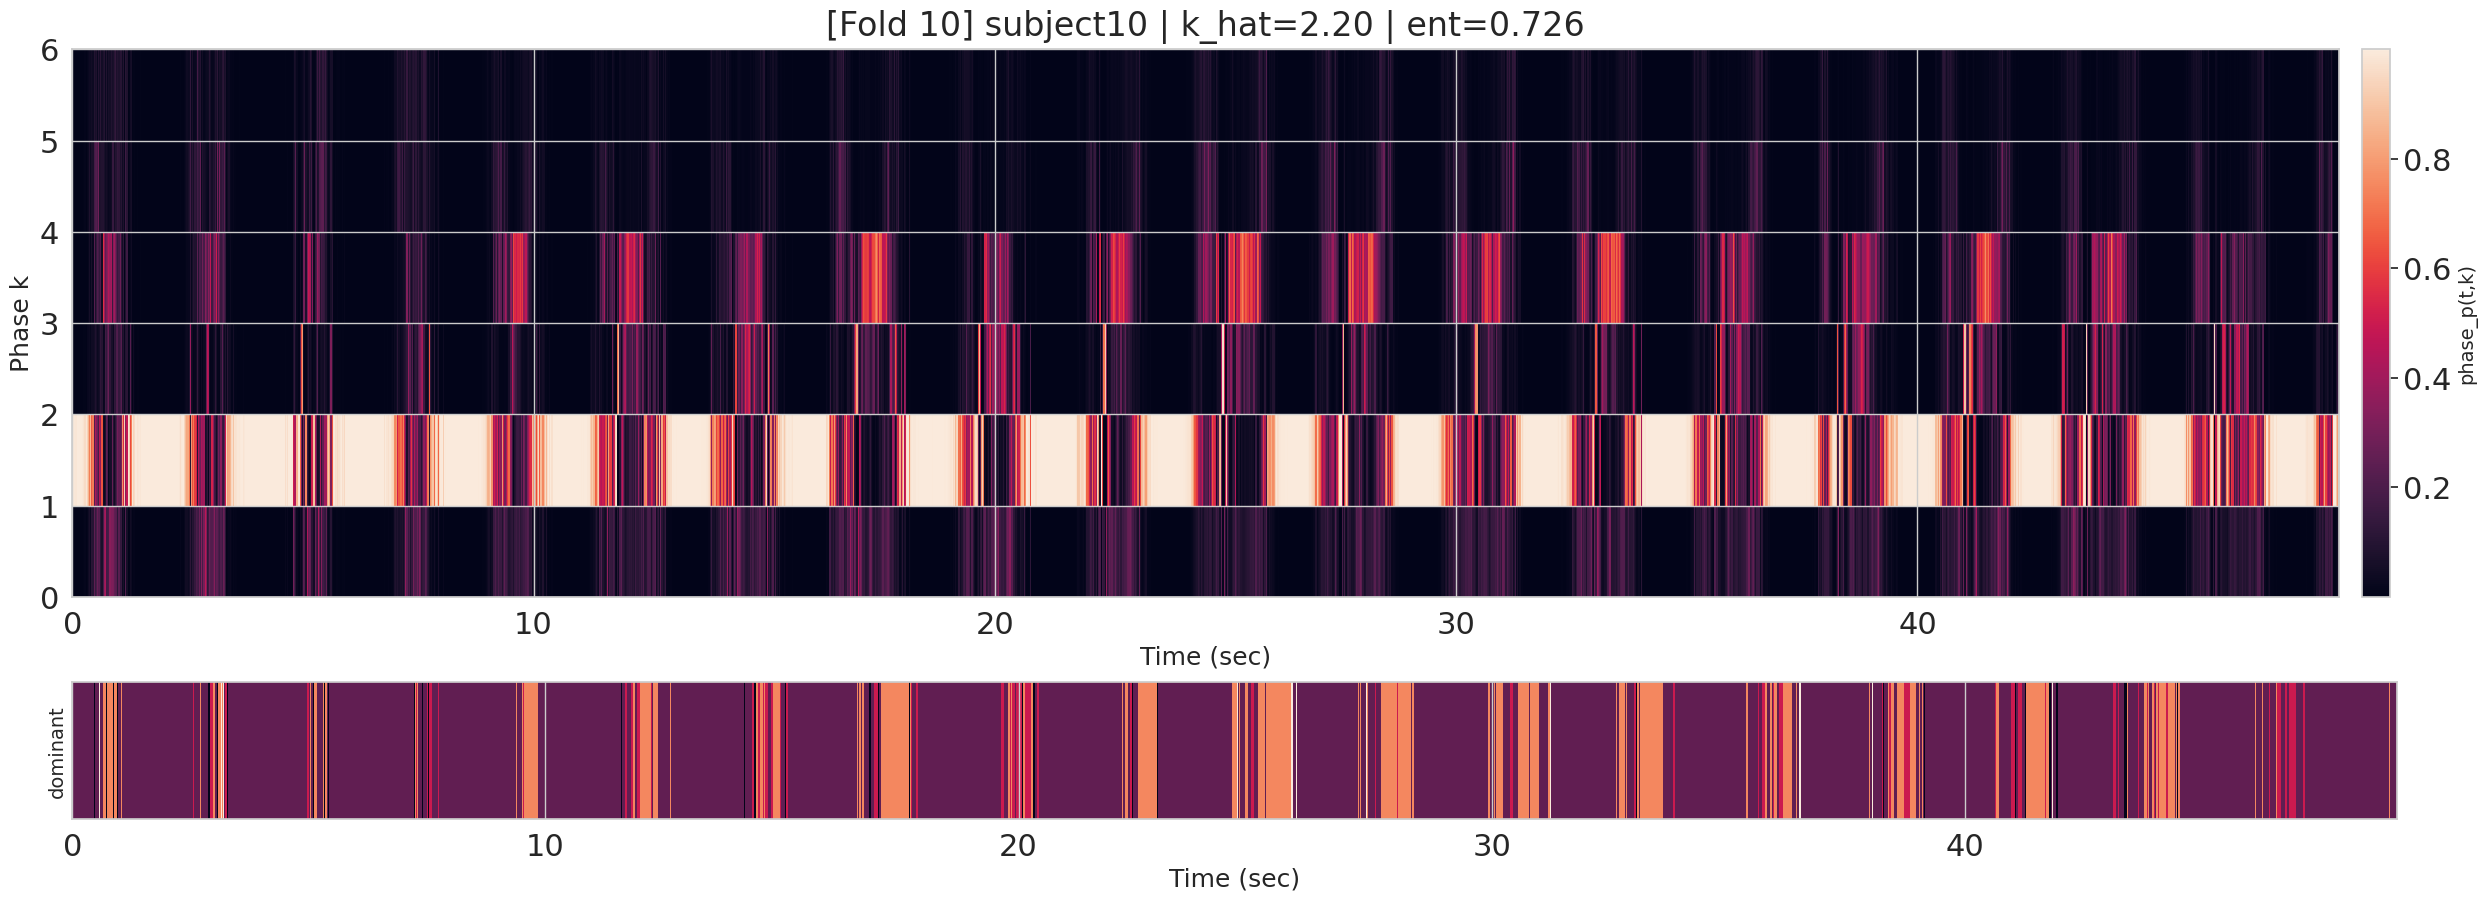

In [1]:
# =========================
# Count-only K-auto (Multi-event) version  (NO manual Pair/lag/overlap/balance)
#
# 핵심 아이디어
# - Micro-event Rate 예측: 모델은 하나의 통합된 속도가 아니라, K_max개의 서로 다른 '작은 단위 동작'의 속도 흐름(r_k(t))을 예측
# - 샘플마다 "rep당 micro-event 개수" k_hat(>=1)을 스스로 추정
# - 우리가 주는 감독은 오직 rep count(=20) -> rep rate만 맞추게
#
# 1) rate head를 amp(t) * softmax(phase) 형태로 바꿔서 K-stream 간 "경쟁"이 생기게 함
# 2) k_hat을 따로 head로 예측하지 않고, phase 사용 분포로부터 effK(=effective K)로 정의 (자동 K)
# 3) phase sparsity/exclusivity를 위해 (a) phase entropy loss, (b) effK usage loss 추가
# =========================

import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ---------------------------------------------------------------------
# 1) Strict Seeding
# ---------------------------------------------------------------------
def set_strict_seed(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ---------------------------------------------------------------------
# 2) Data Loading
# ---------------------------------------------------------------------
def load_mhealth_dataset(data_dir, target_activities_map, column_names):
    full_dataset = {}
    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"[Warning] No mHealth logs found in {data_dir}")
        return {}

    print(f"Loading {len(file_list)} subjects from {data_dir}...")

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_part = file_name.split('.')[0]
        try:
            subj_id_num = int(''.join(filter(str.isdigit, subj_part)))
            subj_key = f"subject{subj_id_num}"
        except:
            subj_key = subj_part

        try:
            df = pd.read_csv(file_path, sep="\t", header=None)
            df = df.iloc[:, :len(column_names)]
            df.columns = column_names

            subj_data = {}
            for label_code, activity_name in target_activities_map.items():
                activity_df = df[df['activity_id'] == label_code].copy()
                if not activity_df.empty:
                    subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

            full_dataset[subj_key] = subj_data
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            pass

    return full_dataset


def prepare_trial_list(label_config, full_data, target_map, feature_map):
    trial_list = []
    for subj, act_id, gt_count in label_config:
        act_name = target_map.get(act_id)
        feats = feature_map.get(act_id)

        if subj in full_data and act_name in full_data[subj]:
            raw_df = full_data[subj][act_name][feats]
            raw_np = raw_df.values.astype(np.float32)

            # Z-score 정규화 (표준화) 평균=0, std=1
            mean = raw_np.mean(axis=0)
            std = raw_np.std(axis=0) + 1e-6
            norm_np = (raw_np - mean) / std

            trial_list.append({
                'data': norm_np,
                'count': float(gt_count),
                'meta': f"{subj}_{act_name}"
            })
        else:
            print(f"[Skip] Missing data for {subj} - {act_name}")

    return trial_list


class TrialDataset(Dataset):
    def __init__(self, trial_list):
        self.trials = trial_list

    def __len__(self):
        return len(self.trials)

    def __getitem__(self, idx):
        item = self.trials[idx]
        data = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1)  # (C, T)
        count = torch.tensor(item['count'], dtype=torch.float32)
        return data, count, item['meta']


def collate_variable_length(batch):
    max_len = max([x[0].shape[1] for x in batch])
    C = batch[0][0].shape[0]

    padded_data, masks, counts, metas, lengths = [], [], [], [], []
    for data, count, meta in batch:
        T = data.shape[1]
        lengths.append(T)

        pad_size = max_len - T
        if pad_size > 0:
            pad = torch.zeros(C, pad_size)
            d_padded = torch.cat([data, pad], dim=1)
            mask = torch.cat([torch.ones(T), torch.zeros(pad_size)], dim=0)
        else:
            d_padded = data
            mask = torch.ones(T)

        padded_data.append(d_padded)
        masks.append(mask)
        counts.append(count)
        metas.append(meta)

    return {
        "data": torch.stack(padded_data),         # (B, C, T_max)
        "mask": torch.stack(masks),               # (B, T_max)
        "count": torch.stack(counts),             # (B,)
        "length": torch.tensor(lengths, dtype=torch.float32),  # (B,)
        "meta": metas
    }


# ---------------------------------------------------------------------
# 3) Model
# ---------------------------------------------------------------------
class ManifoldEncoder(nn.Module):
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(input_ch, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, latent_dim, 1)
        )

    def forward(self, x):
        # x: (B, C, T)
        z = self.net(x)            # (B, D, T)
        z = z.transpose(1, 2)      # (B, T, D)
        return z


class ManifoldDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(latent_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, out_ch, 1)
        )

    def forward(self, z):
        # z: (B, T, D)
        zt = z.transpose(1, 2)     # (B, D, T)
        x_hat = self.net(zt)       # (B, C, T)
        return x_hat


class MultiRateHead(nn.Module):
    def __init__(self, latent_dim=16, hidden=64, K_max=6):
        super().__init__()
        self.K_max = K_max
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1 + K_max)  # [amp_logit | phase_logits...]
        )

    def forward(self, z, tau=1.0):
        # z: (B,T,D)
        out = self.net(z)                     # (B,T,1+K)
        amp = F.softplus(out[..., 0])         # (B,T) >=0  (total micro intensity)
        phase_logits = out[..., 1:]           # (B,T,K)
        phase = F.softmax(phase_logits / tau, dim=-1)  # (B,T,K), sum=1
        return amp, phase, phase_logits


class KAutoCountModel(nn.Module):
    """
    - outputs K_max micro-event rates r_k(t)
    - predicts k_hat (>=1) per sample
    - rep_rate(t) = sum_k r_k(t) (모든 micro-event 합) / k_hat
    """
    def __init__(self, input_ch, hidden_dim=128, latent_dim=16, K_max=6, k_hidden=64):
        super().__init__()
        self.encoder = ManifoldEncoder(input_ch, hidden_dim, latent_dim)
        self.decoder = ManifoldDecoder(latent_dim, hidden_dim, input_ch)
        self.rate_head = MultiRateHead(latent_dim, hidden=hidden_dim, K_max=K_max)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        with torch.no_grad():
            b = self.rate_head.net[-1].bias
            b.zero_()
            b[0].fill_(-2.0)  # amp logit bias만 -2

    @staticmethod
    def _masked_mean_time(x, mask=None, eps=1e-6):
        # x: (B,T) or (B,T,K)
        if mask is None:
            return x.mean(dim=1)
        if x.dim() == 2:
            m = mask.to(dtype=x.dtype, device=x.device)            # (B,T)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)       # (B,)
        elif x.dim() == 3:
            m = mask.to(dtype=x.dtype, device=x.device).unsqueeze(-1)  # (B,T,1)
            return (x * m).sum(dim=1) / (m.sum(dim=1) + eps)           # (B,K)
        else:
            raise ValueError(f"Unsupported dim for masked mean: {x.dim()}")

    def forward(self, x, mask=None, tau=1.0):
        """
        x: (B,C,T), mask: (B,T)
        return:
          avg_rep_rate: (B,)
        """
        z = self.encoder(x)              # (B,T,D)
        x_hat = self.decoder(z)          # (B,C,T)

        amp_t, phase_p, phase_logits = self.rate_head(z, tau=1.0)
        rates_k_t = amp_t.unsqueeze(-1) * phase_p

        # micro-event sum
        micro_rate_t = amp_t


        p_bar = self._masked_mean_time(phase_p, mask)           # (B,K)
        k_hat = 1.0 / (p_bar.pow(2).sum(dim=1) + 1e-6)          # (B,) in [1,K]

        # rep rate
        rep_rate_t = micro_rate_t / (k_hat.unsqueeze(1) + 1e-6)    # (B,T)
        if mask is not None:
            rep_rate_t = rep_rate_t * mask

        # avg rep rate (masked mean)
        if mask is None:
            avg_rep_rate = rep_rate_t.mean(dim=1)
        else:
            avg_rep_rate = (rep_rate_t * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-6)

        aux = {
            "rates_k_t": rates_k_t,          # (B,T,K)
            "phase_p": phase_p,              # (B,T,K)
            "phase_logits": phase_logits,    # (B,T,K)
            "micro_rate_t": micro_rate_t,    # (B,T)
            "rep_rate_t": rep_rate_t,        # (B,T)
            "k_hat": k_hat,                  # (B,)
        }
        return avg_rep_rate, z, x_hat, aux


# ---------------------------------------------------------------------
# 4) Loss utils
# ---------------------------------------------------------------------
def masked_recon_mse(x_hat, x, mask, eps=1e-6):
    mask = mask.to(dtype=x.dtype, device=x.device)
    mask_bc = mask.unsqueeze(1)              # (B,1,T)
    se = (x_hat - x) ** 2                    # (B,C,T)
    se = se * mask_bc
    denom = (mask.sum() * x.shape[1]) + eps  # valid(B*T)*C
    return se.sum() / denom


def temporal_smoothness(v, mask=None, eps=1e-6):
    """
    v: (B,T) -> L1 smoothness on first difference
    """
    dv = torch.abs(v[:, 1:] - v[:, :-1])  # (B,T-1)
    if mask is None:
        return dv.mean()
    m = mask[:, 1:] * mask[:, :-1]
    m = m.to(dtype=dv.dtype, device=dv.device)
    return (dv * m).sum() / (m.sum() + eps)


def phase_entropy_loss(phase_p, mask=None, eps=1e-8):
    """
    time-wise exclusivity: 각 t에서 phase가 one-hot에 가까워지게(entropy 최소화)
    phase_p: (B,T,K)
    """
    ent = -(phase_p * (phase_p + eps).log()).sum(dim=-1)  # (B,T)
    if mask is None:
        return ent.mean()
    ent = ent * mask
    return ent.sum() / (mask.sum() + eps)


def effK_usage_loss(phase_p, mask=None, eps=1e-6):
    """
    overall usage sparsity: time-avg phase usage의 effective-K를 줄이게
    effK = 1 / sum(p_bar^2)  in [1,K]
    """
    if mask is None:
        p_bar = phase_p.mean(dim=1)  # (B,K)
    else:
        m = mask.to(dtype=phase_p.dtype, device=phase_p.device).unsqueeze(-1)  # (B,T,1)
        p_bar = (phase_p * m).sum(dim=1) / (m.sum(dim=1) + eps)

    effK = 1.0 / (p_bar.pow(2).sum(dim=1) + eps)
    return effK.mean(), effK.detach()


# ---------------------------------------------------------------------
# 5) Train
# ---------------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, config, device):
    model.train()
    stats = {k: 0.0 for k in [
        'loss', 'loss_rate', 'loss_recon', 'loss_smooth', 'loss_phase_ent', 'loss_effk',
        'mae_count'
    ]}

    fs = config["fs"]
    tau = config.get("tau", 1.0)

    lam_recon = config.get("lambda_recon", 1.0)
    lam_smooth = config.get("lambda_smooth", 0.05)
    lam_phase_ent = config.get("lambda_phase_ent", 0.01)
    lam_effk = config.get("lambda_effk", 0.005)

    for batch in loader:
        x = batch["data"].to(device)         # (B,C,T)
        mask = batch["mask"].to(device)      # (B,T)
        y_count = batch["count"].to(device)  # (B,)
        length = batch["length"].to(device)  # (B,)

        duration = torch.clamp(length / fs, min=1e-6)  # sec
        y_rate = y_count / duration                    # reps/s

        optimizer.zero_grad()

        rate_hat, z, x_hat, aux = model(x, mask, tau=tau)

        # (1) 속도 맞추기 (MSE Loss)
        loss_rate = F.mse_loss(rate_hat, y_rate)

        # (2) recon
        loss_recon = masked_recon_mse(x_hat, x, mask)

        # (3) smoothness (rep_rate_t 기준)
        loss_smooth = temporal_smoothness(aux["rep_rate_t"], mask)

        # (4) phase exclusivity (entropy)
        loss_phase_ent = phase_entropy_loss(aux["phase_p"], mask)

        # (5) effective-K usage (overall)
        loss_effk, _ = effK_usage_loss(aux["phase_p"], mask)

        loss = (loss_rate
                + lam_recon * loss_recon
                + lam_smooth * loss_smooth
                + lam_phase_ent * loss_phase_ent
                + lam_effk * loss_effk)

        loss.backward()
        optimizer.step()

        # MAE on count
        count_hat = rate_hat * duration  # 예측 속도 * 시간 = 예측 개수
        stats['loss'] += loss.item()
        stats['loss_rate'] += loss_rate.item()
        stats['loss_recon'] += loss_recon.item()
        stats['loss_smooth'] += loss_smooth.item()
        stats['loss_phase_ent'] += loss_phase_ent.item()
        stats['loss_effk'] += loss_effk.item()
        stats['mae_count'] += torch.abs(count_hat - y_count).mean().item()

    n = len(loader)
    return {k: v / n for k, v in stats.items()}


# ---------------------------------------------------------------------
# 6) Visualization helpers (subject-wise subplot)
# ---------------------------------------------------------------------
def _smooth_1d(y, sigma=2.0):
    """
    지저분한 노이즈를 다듬어서 시각화
    """
    y = np.asarray(y, dtype=np.float32)
    return gaussian_filter1d(y, sigma=sigma)


def compute_phase_entropy_mean(phase_p_np, eps=1e-8):
    """
    phase_p_np: (T,K) numpy
    return: time-avg entropy (scalar)
    """
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)
    ent_t = -(phase_p_np * np.log(phase_p_np + eps)).sum(axis=1)  # (T,)
    return float(ent_t.mean())

def downsample_time_axis(arr, max_T=2000):
    """
    arr: (T, ...) numpy
    너무 길면 시각화가 깨지므로 T를 max_T로 downsample
    return: arr_ds, idx (원래 시간 인덱스)
    """
    T = arr.shape[0]
    if T <= max_T:
        idx = np.arange(T)
        return arr, idx
    idx = np.linspace(0, T - 1, max_T).astype(int)
    return arr[idx], idx


def plot_phase_heatmap_and_dominant(
    phase_p_np,
    fs,
    title="phase_p heatmap + dominant phase",
    max_T=2000
):
    """
    phase_p_np: (T, K) numpy array
    fs: sampling rate
    max_T: 시각화 다운샘플링 길이
    """
    phase_p_np = np.asarray(phase_p_np, dtype=np.float32)
    assert phase_p_np.ndim == 2, f"phase_p_np must be (T,K), got {phase_p_np.shape}"

    # (1) downsample for visualization
    phase_ds, idx = downsample_time_axis(phase_p_np, max_T=max_T)  # (T',K)
    Tds, K = phase_ds.shape
    t_sec = idx / float(fs)

    # (2) dominant phase (argmax)
    dom = np.argmax(phase_ds, axis=1)  # (T',)

    # (3) plot
    fig = plt.figure(figsize=(30, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0.25)

    # --- Heatmap (top) ---
    ax0 = fig.add_subplot(gs[0, 0])
    # imshow expects (rows, cols) -> we want y=K, x=T
    im = ax0.imshow(
        phase_ds.T,                 # (K, T')
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        extent=[t_sec[0], t_sec[-1], 0, K]   # x=time, y=phase index range
    )
    ax0.set_title(title, fontsize=24, pad=10)
    ax0.set_ylabel("Phase k", fontsize=18)
    ax0.set_xlabel("Time (sec)", fontsize=18)
    cbar = fig.colorbar(im, ax=ax0, fraction=0.015, pad=0.01)
    cbar.set_label("phase_p(t,k)", fontsize=14)

    # --- Dominant phase timeline (bottom) ---
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
    # dominant phase를 1행짜리 이미지로 보여주면 가장 깔끔함
    ax1.imshow(
        dom[None, :],               # (1, T')
        aspect="auto",
        origin="lower",
        interpolation="nearest",
        extent=[t_sec[0], t_sec[-1], 0, 1]
    )
    ax1.set_yticks([])
    ax1.set_ylabel("dominant", fontsize=14)
    ax1.set_xlabel("Time (sec)", fontsize=18)

    plt.tight_layout()
    plt.show()


def plot_folds_test_subplot(viz_cache, fs, title="Fold-wise TEST visualization (only test_subj)"):
    """
    viz_cache: list of dict
      each dict contains:
        - 'fold', 'test_subj', 't', 'rep_rate', 'gt', 'pred', 'diff', 'k_hat', 'entropy'
    """
    if viz_cache is None or len(viz_cache) == 0:
        print("[plot_folds_test_subplot] viz_cache is empty")
        return

    sns.set_theme(style="whitegrid", context="notebook", font_scale=2.0)
    colors = sns.color_palette("muted")
    c_rate = colors[0]
    c_count = colors[1]

    n = len(viz_cache)
    fig, axes = plt.subplots(n, 1, figsize=(36, 9 * n), sharex=False)
    if n == 1:
        axes = [axes]
    axes = np.array(axes).flatten()

    fig.suptitle(title, fontsize=40, y=0.995)

    for i, item in enumerate(viz_cache):
        ax = axes[i]

        t = item["t"]
        rep_rate = item["rep_rate"]
        gt_count = item["gt"]
        pred_count = item["pred"]
        diff = item["diff"]
        k_hat = item["k_hat"]
        entropy = item["entropy"]
        test_subj = item["test_subj"]
        fold = item["fold"]

        rep_s = _smooth_1d(rep_rate, sigma=2.0)
        cum = np.cumsum(rep_rate) / fs

        # 왼쪽: rep_rate
        ax.plot(t, rep_s, color=c_rate, linewidth=2.5, alpha=0.9)
        ax.fill_between(t, rep_s, color=c_rate, alpha=0.15)
        ax.set_ylabel("Rep Rate (reps/s)", color=c_rate, fontweight='bold', fontsize=24)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=20)

        # 오른쪽: cumulative count
        ax2 = ax.twinx()
        ax2.plot(t, cum, color=c_count, linewidth=3.5, alpha=1.0)
        ax2.axhline(gt_count, linestyle=":", alpha=0.7)
        ax2.set_ylabel("Count", color=c_count, fontweight='bold', fontsize=24)
        ax2.tick_params(axis='y', labelcolor=c_count, labelsize=20)
        ax2.grid(False)

        ax.set_title(
            f"Fold {fold:2d} | Test: {test_subj} | Pred {pred_count:.2f} / GT {gt_count:.0f} (Diff {diff:+.2f})\n"
            f"k_hat={k_hat:.2f} | phase_entropy={entropy:.3f}",
            fontsize=34, pad=10
        )
        ax.set_xlabel("Time (sec)", fontweight='bold', fontsize=24)

    plt.tight_layout(rect=[0, 0, 1, 0.985])
    plt.subplots_adjust(hspace=0.5)
    plt.show()


# ---------------------------------------------------------------------
# 7) Main (LOSO)
# ---------------------------------------------------------------------
def main():
    CONFIG = {
        "seed": 42,
        "data_dir": "/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET",

        "COLUMN_NAMES": [
            'acc_chest_x', 'acc_chest_y', 'acc_chest_z',
            'ecg_1', 'ecg_2',
            'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',
            'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
            'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',
            'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
            'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',
            'mag_arm_x', 'mag_arm_y', 'mag_arm_z',
            'activity_id'
        ],
        "TARGET_ACTIVITIES_MAP": {
            6: 'Waist bends forward',
        },
        "ACT_FEATURE_MAP": {
            6: ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
                'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z'],
        },

        # Training Params
        "epochs": 100,
        "lr": 5e-4,
        "batch_size": 64,
        "fs": 50,

        # Model
        "hidden_dim": 128,
        "latent_dim": 16,
        "K_max": 6,

        # Loss Weights
        "lambda_recon": 1.0,
        "lambda_smooth": 0.05,
        "lambda_phase_ent": 0.01,
        "lambda_effk": 0.005,

        # temperature (phase 경쟁 강도)
        "tau": 1.0,

        # Count-only labels (rep 기준)
        "ALL_LABELS": [
            ("subject1", 6, 21),
            ("subject2", 6, 19),
            ("subject3", 6, 21),
            ("subject4", 6, 20),
            ("subject5", 6, 20),
            ("subject6", 6, 20),
            ("subject7", 6, 20),
            ("subject8", 6, 21),
            ("subject9", 6, 21),
            ("subject10", 6, 20),
        ],
    }

    set_strict_seed(CONFIG["seed"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    full_data = load_mhealth_dataset(CONFIG["data_dir"], CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["COLUMN_NAMES"])
    if not full_data:
        return

    subjects = [f"subject{i}" for i in range(1, 11)]
    loso_results = []

    print("\n" + "-"*80)
    print(" >>> Starting LOSO (count-only, K-auto)")
    print("-"*80)

    last_trained_model = None
    viz_cache = []

    for fold_idx, test_subj in enumerate(subjects):
        set_strict_seed(CONFIG["seed"])

        train_labels = [x for x in CONFIG["ALL_LABELS"] if x[0] != test_subj]
        test_labels  = [x for x in CONFIG["ALL_LABELS"] if x[0] == test_subj]

        train_data = prepare_trial_list(train_labels, full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])
        test_data  = prepare_trial_list(test_labels,  full_data, CONFIG["TARGET_ACTIVITIES_MAP"], CONFIG["ACT_FEATURE_MAP"])

        if not test_data:
            print(f"[Skip] Fold {fold_idx+1}: {test_subj} has no data.")
            continue

        g = torch.Generator()
        g.manual_seed(CONFIG["seed"])

        train_loader = DataLoader(
            TrialDataset(train_data),
            batch_size=CONFIG["batch_size"],
            shuffle=True,
            collate_fn=collate_variable_length,
            generator=g,
            num_workers=0
        )

        input_ch = train_data[0]['data'].shape[1]
        model = KAutoCountModel(
            input_ch=input_ch,
            hidden_dim=CONFIG["hidden_dim"],
            latent_dim=CONFIG["latent_dim"],
            K_max=CONFIG["K_max"]
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

        for epoch in range(CONFIG["epochs"]):
            stats = train_one_epoch(model, train_loader, optimizer, CONFIG, device)
            scheduler.step()

        model.eval()
        last_trained_model = model

        # fold test
        fold_mae = 0.0
        fold_res_str = ""

        # summary용
        test_gt = None
        test_pred = None
        test_diff = None
        test_khat = None
        test_entropy = None

        # 시각화 캐시용
        test_t = None
        test_rep_rate = None
        test_phase_p = None

        for item in test_data:
            with torch.no_grad():
                x_tensor = torch.tensor(item['data'], dtype=torch.float32).transpose(0, 1).unsqueeze(0).to(device)
                duration = x_tensor.shape[2] / CONFIG["fs"]

                rate_hat, _, _, aux = model(x_tensor, mask=None)
                count_pred = rate_hat.item() * duration # 모델이 예측한 속도(rate) * 시간(duration) = 예측 개수
                count_gt = float(item['count'])

                abs_err = abs(count_pred - count_gt)  # 실제 개수와의 차이 (절대오차)
                fold_mae += abs_err
                fold_res_str += f"[Pred: {count_pred:.1f} / GT: {count_gt:.0f}]"

                # test summary(표현학습 확인용) 값 저장
                phase_p = aux["phase_p"].squeeze(0).detach().cpu().numpy()  # (T,K)
                k_hat = float(aux["k_hat"].item())
                ent = compute_phase_entropy_mean(phase_p)

                test_gt = count_gt
                test_pred = float(count_pred)
                test_diff = float(count_pred - count_gt)
                test_khat = k_hat
                test_entropy = ent

                # subplot용 rep_rate 저장
                rep_rate = aux["rep_rate_t"].squeeze(0).detach().cpu().numpy()  # (T,)
                T = rep_rate.shape[0]
                test_rep_rate = rep_rate
                test_t = np.arange(T) / CONFIG["fs"]
                test_phase_p = phase_p

        fold_mae /= len(test_data)
        loso_results.append(fold_mae)

        print(f"Fold {fold_idx+1:2d} | Test: {test_subj} | MAE: {fold_mae:.2f} | {fold_res_str}")

        if (test_gt is not None) and (test_pred is not None):
            print(
                f"[Fold TEST Summary] {test_subj} | GT={test_gt:.0f} | Pred={test_pred:.2f} | "
                f"Diff={test_diff:+.2f} | k_hat={test_khat:.2f} | phase_entropy={test_entropy:.3f}"
            )

        if (test_t is not None) and (test_rep_rate is not None):
            viz_cache.append({
                "fold": fold_idx + 1,
                "test_subj": test_subj,
                "t": test_t,
                "rep_rate": test_rep_rate,
                "gt": float(test_gt) if test_gt is not None else 0.0,
                "pred": float(test_pred) if test_pred is not None else 0.0,
                "diff": float(test_diff) if test_diff is not None else 0.0,
                "k_hat": float(test_khat) if test_khat is not None else 0.0,
                "entropy": float(test_entropy) if test_entropy is not None else 0.0,
                "phase_p": phase_p,
            })

    print("-"*80)
    print(f" >>> Final LOSO Result (Average MAE): {np.mean(loso_results):.3f}")
    print(f" >>> Standard Deviation: {np.std(loso_results):.3f}")
    print("-"*80)

    plot_folds_test_subplot(
        viz_cache,
        fs=CONFIG["fs"],
        title="Fold-wise TEST visualization (only test_subj)"
    )

    for item in viz_cache:
        plot_phase_heatmap_and_dominant(
            item["phase_p"],
            fs=CONFIG["fs"],
            title=f"[Fold {item['fold']:2d}] {item['test_subj']} | k_hat={item['k_hat']:.2f} | ent={item['entropy']:.3f}",
            max_T=2000
        )

if __name__ == "__main__":
    main()